# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit', 
                                        target_folder='lectures', batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text':1, 'author':1}, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15, class_id='text'))
model.scores.add(artm.TopTokensScore(name='top_authors', num_tokens=15, class_id='author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, dictionary='dict', class_ids='text', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
tn = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, dictionary='dict', class_ids='text', topic_names=tn))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
tokens = model.score_tracker['top_words'].last_tokens
for topic in model.topic_names:
    print topic + ': ',
    for word in tokens[topic]:
        print word + ' ',
    print 

sbj0:  его  власть  александр  писать  век  великий  историк  имя  римский  знаменитый  король  церковь  реформа  мысль  средневековый 
sbj1:  там  земля  планета  находиться  интересный  тело  температура  открывать  раз  маленький  обнаруживать  поверхность  вокруг  образовываться  двигаться 
sbj2:  система  чтобы  между  создавать  сложный  общий  направление  простой  движение  ответ  способность  трудность  переход  компонент  искусственный 
sbj3:  говорить  сторона  понятие  всегда  отвечать  представление  лицо  отличаться  предмет  концепция  опыт  меняться  рассматривать  кто-то  восприятие 
sbj4:  вид  появляться  каждый  вещь  любой  иной  качество  мой  нельзя  этап  особый  оценка  деятельность  естественный  основание 
sbj5:  можно  при  получать  структура  использовать  материал  достаточно  свойство  сделать  элемент  пора  применение  устройство  класс  физический 
sbj6:  книга  научный  написать  тема  выходить  автор  фильм  массовый  документ  герой  театр  посвяща

In [13]:
tokens = model.score_tracker['top_authors'].last_tokens
for topic, words in sorted(tokens.items()):
    print topic + ': ',
    for word in words:
        print word + ' ',
    print 

bcg:  Мария_Фаликман  Михаил_Соколов  Виталий_Куренной  Михаил_Гельфанд  Михаил_Алексеевский  Александр_Филиппов  Алексей_Миллер  Елена_Брызгалина  Алексей_Маслов  Алексей_Акимов  Андрей_Зорин  Виктор_Вахштайн  Алексей_Семихатов  Алексей_Желтиков  Сергей_Зенкин 
sbj0:  Александр_Марей  Фёдор_Успенский  Павел_Уваров  Татьяна_Бобровникова  Ольга_Вайнштейн  Михаил_Бойцов  Алексей_Юдин  Игорь_Данилевский  Раиса_Кирсанова  Владимир_Кантор  Елена_Браун  Игорь_Курукин  Елена_Уханова  Борис_Морозов  Екатерина_Болтунова 
sbj1:  Елизавета_Бонч-Осмоловская  Кирилл_Еськов  Сергей_Попов  Дмитрий_Титов  Николай_Пименов  Татьяна_Смоктунович  Андрей_Иванцов  Зоригто_Намсараев  Светлана_Дедыш  Александр_Марков  Сергей_Наугольных  Елизавета_Ривкина  Александр_Слободкин  Наталья_Новикова  Роман_Рафиков 
sbj10:  Кирилл_Кочегаров  Кирилл_Соловьев  Ирина_Бёме  Олег_Будницкий  Сергей_Соколовский  Варвара_Добровольская  Александр_Лаврентьев  Борис_Колоницкий  Александр_Каменский  Борис_Морозов  Алексей_Бартош

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = [u'История средних веков', u'Космос', u'Системы', u'Философия', u'Биология', 
 u'Материалы', u'Культура', u'Социология', u'Химия', u'Квантовая физика', 
 u'История России', u'Воспитание', u'Мозг', u'История городов', u'Астрономия', 
 u'Анализ', u'Общее', u'Политика', u'Язык', u'Обществознание', 
 u'Технологии будущего', u'Медицина', u'Информатика', u'Математика', u'История', 
 u'Лингвистика', u'Психология', u'Генетика', u'Наука и образование']
# sbj_topic_labels = []   # запишите названия тем в список
#tokens = model.score_tracker['top_words'].last_tokens
#for topic in model.topic_names[:-1]:
#    sbj_topic_labels.append(tokens[topic][0])
topic_labels = sbj_topic_labels + [u'Фоновая тема']

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi = model.get_phi(class_ids='author')
theta = model.get_theta()
print phi.shape, theta.shape

(539, 30) (30, 1728)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

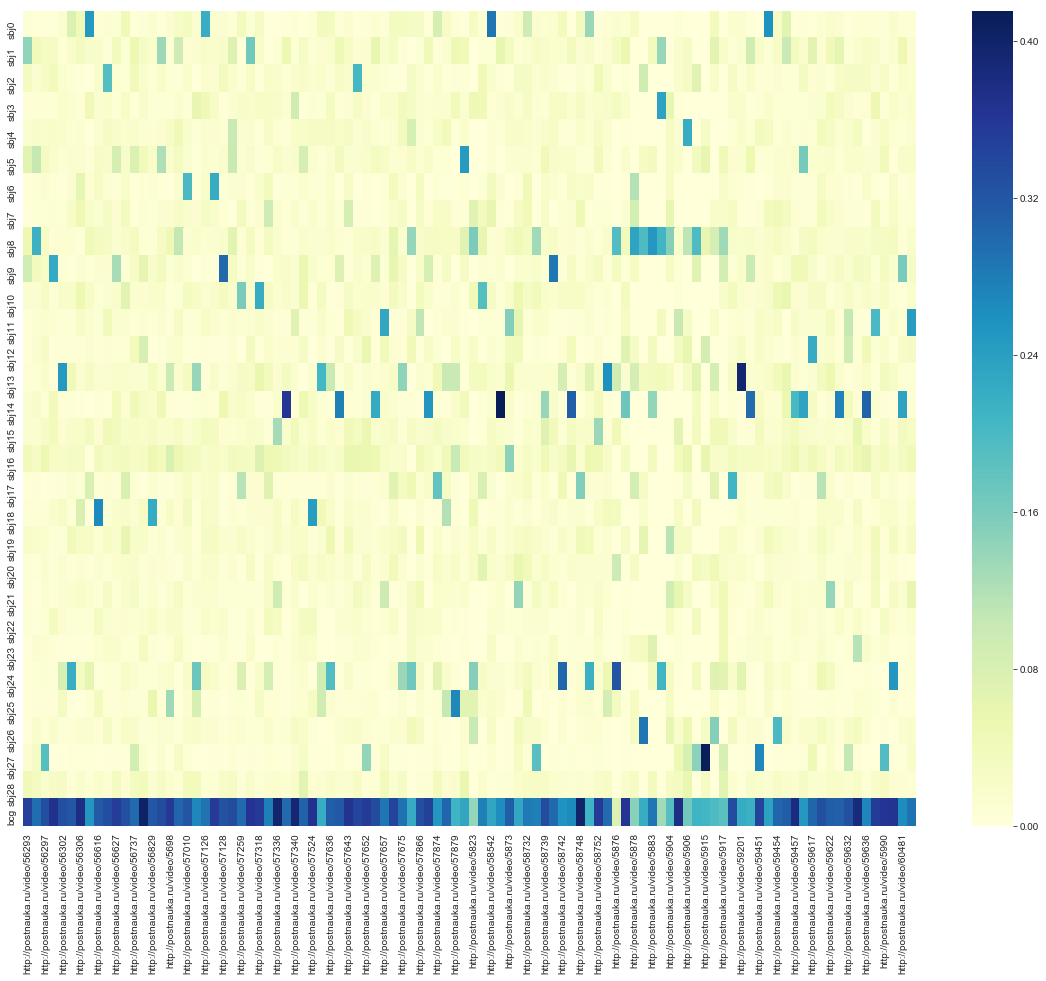

In [31]:
# Ваш код
plt.figure(figsize=(20,15))
seaborn.heatmap(theta.iloc[:, :100], cmap='YlGnBu')

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [17]:
# Ваш код
prob = theta.sum(axis=1)
prob = prob / prob.sum()
prob = pd.Series(data=prob.values, index=topic_labels)
prob

История средних веков    0.027329
Космос                   0.028970
Системы                  0.018734
Философия                0.020520
Биология                 0.018213
Материалы                0.027626
Культура                 0.013373
Социология               0.022999
Химия                    0.052511
Квантовая физика         0.036821
История России           0.023550
Воспитание               0.017078
Мозг                     0.021983
История городов          0.032975
Астрономия               0.031690
Анализ                   0.024325
Общее                    0.030248
Политика                 0.034013
Язык                     0.016742
Обществознание           0.022328
Технологии будущего      0.017699
Медицина                 0.019530
Информатика              0.014075
Математика               0.013171
История                  0.035705
Лингвистика              0.018665
Психология               0.023894
Генетика                 0.029062
Наука и образование      0.023896
Фоновая тема  

In [18]:
print prob.sort_values(ascending=False)[:6]
print prob.sort_values()[:3]

Фоновая тема        0.282276
Химия               0.052511
Квантовая физика    0.036821
История             0.035705
Политика            0.034013
История городов     0.032975
dtype: float32
Математика     0.013171
Культура       0.013373
Информатика    0.014075
dtype: float32


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

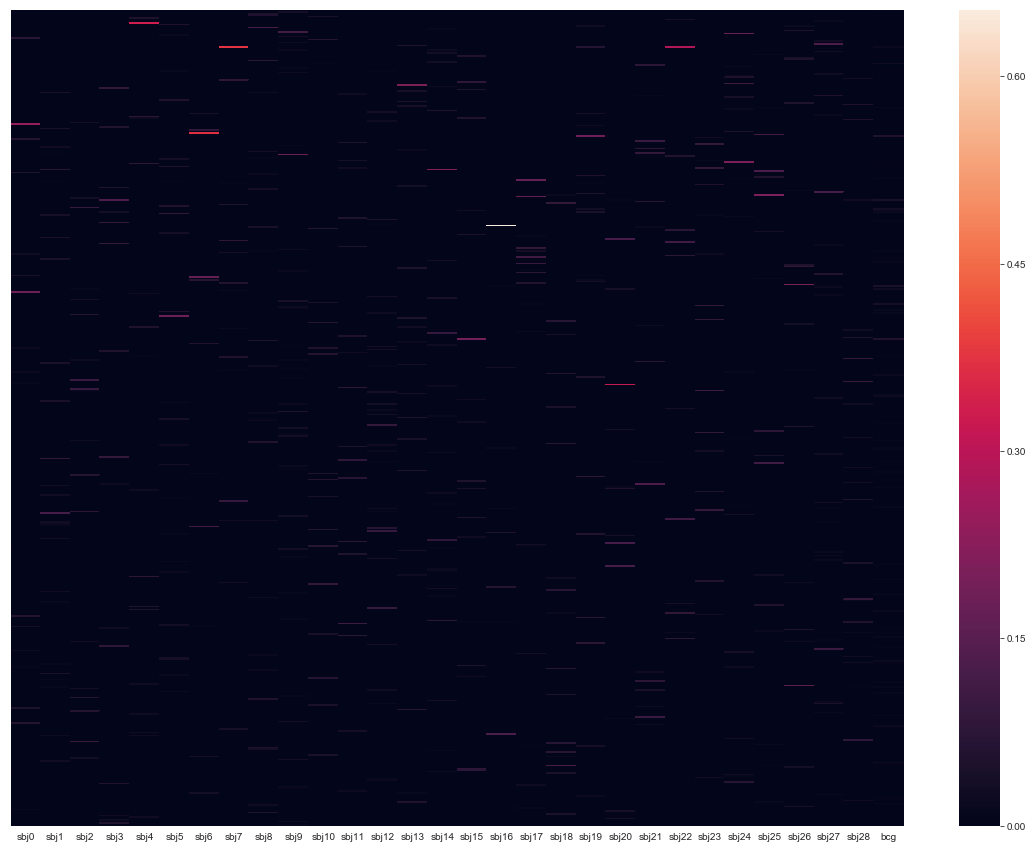

In [19]:
plt.figure(figsize=(20,15))
seaborn.heatmap(phi, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [20]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Ярослав_Исполатов)",0.000000e+00,0.000000e+00,1.617448e-09,1.817318e-11,1.011139e-06,0.000000e+00,0.000000e+00,0.000000e+00,3.504708e-12,0.000000e+00,...,0.000000e+00,1.047870e-07,1.256824e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.425791e-14,3.291446e-12,5.321609e-03
"(author, Сергей_Демокритов)",0.000000e+00,0.000000e+00,2.267499e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.104361e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.100627e-14,7.969739e-11
"(author, Руслан_Смелянский)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.382532e-02,0.000000e+00,...,6.238593e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(author, Александр_Апт)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.382427e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000125e-07,0.000000e+00,2.393981e-09
"(author, Людмила_Новикова)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.269719e-16,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.085663e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.099684e-08
"(author, Александр_Парфенов)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.267310e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(author, Джеффри_Шнапп)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.401298e-05,0.000000e+00,4.016497e-11,0.000000e+00,...,1.328305e-09,0.000000e+00,3.644281e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.018766e-06,2.369367e-08
"(author, Дмитрий_Чудаков)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.239669e-11,0.000000e+00,...,0.000000e+00,2.332508e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.024956e-02,0.000000e+00,0.000000e+00
"(author, Дмитрий_Дождев)",0.000000e+00,0.000000e+00,0.000000e+00,2.639104e-07,3.341590e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.579122e-09
"(author, Владимир_Шалаев)",0.000000e+00,0.000000e+00,1.235984e-14,0.000000e+00,0.000000e+00,5.461223e-02,0.000000e+00,0.000000e+00,9.224637e-10,7.263324e-15,...,1.537455e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.818268e-14,1.938977e-08


In [21]:
authors = phi[phi > 0.01].count(axis=1)
authors = [i[1] for i in authors[authors >=3].index]
for author in authors:
    print author

Виктор_Вахштайн
Виталий_Куренной
Михаил_Маяцкий
Елена_Брызгалина
Михаил_Киселев
Владимир_Муронец


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [22]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [23]:
# Ваш код
prob_theme_author = np.empty(phi.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi.iloc[i,j] * prob.iloc[j] / np.sum(phi.iloc[i,:] * prob.values)

In [24]:
# Ваш код
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

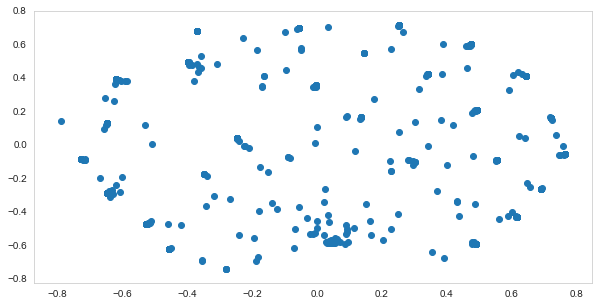

In [25]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

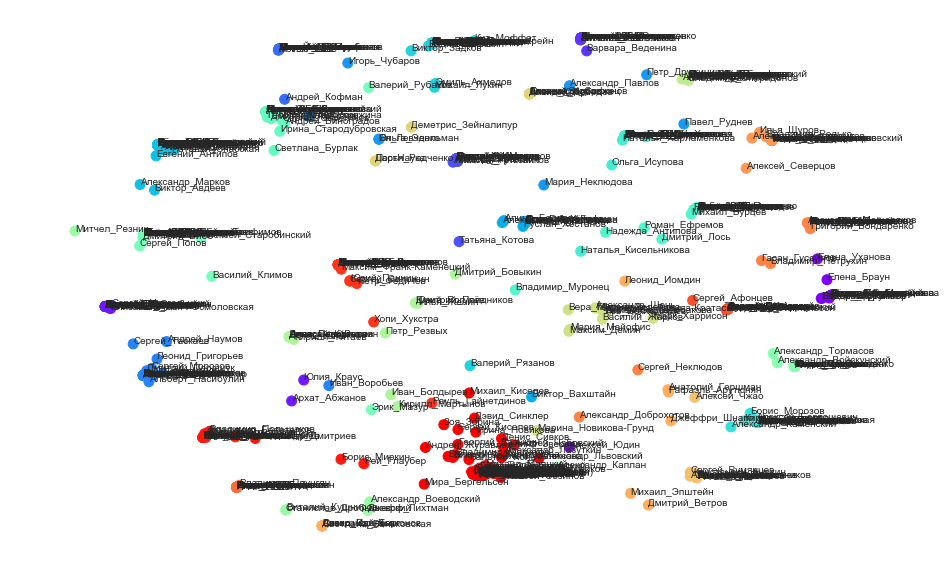

In [26]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi.index):
        plt.annotate(author[1], pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [27]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1085, 1125, 1569, ...,  588,  584,  408],
       [ 547, 1270,  807, ...,  679,  678, 1527],
       [ 647,  347,   37, ...,  146,  804,  741],
       ...,
       [  76,  931,  415, ..., 1553,  497, 1499],
       [ 148,  192,  193, ...,  647,  841,  591],
       [1616, 1700,  324, ..., 1243,  489,  803]], dtype=int64)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [28]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [29]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [30]:
# Ваш код
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Ольга_Вайнштейн Михаил_Бойцов Алексей_Юдин Игорь_Данилевский Раиса_Кирсанова Владимир_Кантор 
http://postnauka.ru/video/3348
http://postnauka.ru/video/3406
http://postnauka.ru/video/5464
http://postnauka.ru/video/24030
http://postnauka.ru/video/24039
http://postnauka.ru/video/9968
http://postnauka.ru/video/14292
http://postnauka.ru/video/28942
http://postnauka.ru/video/31677
http://postnauka.ru/video/23900


Елизавета_Бонч-Осмоловская Кирилл_Еськов Сергей_Попов Дмитрий_Титов Николай_Пименов Татьяна_Смоктунович Андрей_Иванцов Зоригто_Намсараев Светлана_Дедыш Александр_Марков 
http://postnauka.ru/video/24245
http://postnauka.ru/video/15049
http://postnauka.ru/video/9835
http://postnauka.ru/video/32889
http://postnauka.ru/video/13098
http://postnauka.ru/video/26206
http://postnauka.ru/video/49437
http://postnauka.ru/video/25312
http://postnauka.ru/video/31695
http://postnauka.ru/video/49261


Александр_Поддьяков Дмитрий_Громов Михаил_Пантелеев Владимир_Мележик Варвара_Веденина Даниэль_Сельва Антон_Суворов Михаил_Фейгельман Виталий_Пальчиков Алексей_Котов 
http://postnauka.ru/video/3602
http://postnauka.ru/video/51382
http://postnauka.ru/video/57648
http://postnauka.ru/video/41348
http://postnauka.ru/video/56618
http://postnauka.ru/video/25097
http://postnauka.ru/video/47457
http://postnauka.ru/video/28557
http://postnauka.ru/video/37982
http://postnauka.ru/video/34426


Виталий_Куренной Сергей_Арутюнов Владимир_Миронов Максим_Кронгауз Николай_Плотников Алексей_Руткевич Павел_Степанцов Дмитрий_Куракин Дмитрий_Иванов Татьяна_Котова 
http://postnauka.ru/video/12524
http://postnauka.ru/video/7169
http://postnauka.ru/video/17397
http://postnauka.ru/video/5891
http://postnauka.ru/video/17041
http://postnauka.ru/video/37990
http://postnauka.ru/video/11626
http://postnauka.ru/video/7747
http://postnauka.ru/video/52418
http://postnauka.ru/video/47812


Дмитрий_Дождев Евгений_Рогожин Сергей_Майоров Наталья_Смолянская Андрей_Кофман Виктор_Цетлин Марина_Бутовская Александр_Парфенов Татьяна_Гусарова Мохамад_Кассаб 
http://postnauka.ru/video/17913
http://postnauka.ru/video/38009
http://postnauka.ru/video/49262
http://postnauka.ru/video/45717
http://postnauka.ru/video/5906
http://postnauka.ru/video/32632
http://postnauka.ru/video/41345
http://postnauka.ru/video/22570
http://postnauka.ru/video/12574
http://postnauka.ru/video/41100


Артем_Оганов Дмитрий_Паращук Валентин_Крапошин Дмитрий_Гольберг Владимир_Шалаев Евгений_Гудилин Шринивас_Шридхар Леонид_Григорьев Алексей_Хохлов Дмитрий_Клинов 
http://postnauka.ru/video/41686
http://postnauka.ru/video/13544
http://postnauka.ru/video/31182
http://postnauka.ru/video/36490
http://postnauka.ru/video/36657
http://postnauka.ru/video/46379
http://postnauka.ru/video/21285
http://postnauka.ru/video/31682
http://postnauka.ru/video/52256
http://postnauka.ru/video/6608


Александр_Павлов Павел_Руднев Ян_Левченко Ольга_Эдельман Мария_Неклюдова Игорь_Чубаров Мария_Майофис Петр_Дружинин Анна_Рогожина Алексей_Бартошевич 
http://postnauka.ru/video/39723
http://postnauka.ru/video/10759
http://postnauka.ru/video/47202
http://postnauka.ru/video/47208
http://postnauka.ru/video/13541
http://postnauka.ru/video/47204
http://postnauka.ru/video/57127
http://postnauka.ru/video/38510
http://postnauka.ru/video/52416
http://postnauka.ru/video/19330


Виктор_Вахштайн Дмитрий_Рогозин Александр_Гофман Ольга_Артёмова Дмитрий_Бовыкин Елена_Вишленкова Алина_Бодрова Арсений_Хитров Руслан_Хестанов Ольга_Малинова 
http://postnauka.ru/video/48335
http://postnauka.ru/video/3509
http://postnauka.ru/video/17491
http://postnauka.ru/video/20720
http://postnauka.ru/video/6380
http://postnauka.ru/video/17490
http://postnauka.ru/video/50656
http://postnauka.ru/video/15989
http://postnauka.ru/video/49448
http://postnauka.ru/video/51331


Валерий_Фокин Валентин_Ненайденко Александр_Беленький Пётр_Турчин Иван_Сорокин Руслан_Смелянский Александр_Апт Алексей_Малашенко Виктория_Битюкова Александр_Габибов 
http://postnauka.ru/video/8632
http://postnauka.ru/video/19069
http://postnauka.ru/video/7771
http://postnauka.ru/video/13700
http://postnauka.ru/video/12373
http://postnauka.ru/video/9144
http://postnauka.ru/video/13151
http://postnauka.ru/video/12172
http://postnauka.ru/video/11646
http://postnauka.ru/video/7514


Дмитрий_Казаков Эмиль_Ахмедов Михаил_Данилов Алексей_Рубцов Виктор_Брагута Игорь_Волобуев Павел_Пахлов Наталья_Берлофф Сергей_Демокритов Сергей_Троицкий 
http://postnauka.ru/video/13043
http://postnauka.ru/video/22760
http://postnauka.ru/video/18873
http://postnauka.ru/video/43677
http://postnauka.ru/video/14283
http://postnauka.ru/video/18870
http://postnauka.ru/video/2945
http://postnauka.ru/video/24434
http://postnauka.ru/video/7311
http://postnauka.ru/video/47826


Кирилл_Кочегаров Кирилл_Соловьев Ирина_Бёме Олег_Будницкий Сергей_Соколовский Варвара_Добровольская Александр_Лаврентьев Борис_Колоницкий Александр_Каменский Борис_Морозов 
http://postnauka.ru/video/35041
http://postnauka.ru/video/29992
http://postnauka.ru/video/26667
http://postnauka.ru/video/32637
http://postnauka.ru/video/46939
http://postnauka.ru/video/42809
http://postnauka.ru/video/41671
http://postnauka.ru/video/25283
http://postnauka.ru/video/30261
http://postnauka.ru/video/34424


Катерина_Поливанова Мария_Падун Юрий_Яшков Наталья_Харламенкова Наталья_Кисельникова Ольга_Исупова Мария_Медникова Эмери_Браун Владимир_Ковальзон Джеральд_де_Хаан 
http://postnauka.ru/video/22892
http://postnauka.ru/video/22883
http://postnauka.ru/video/11361
http://postnauka.ru/video/60527
http://postnauka.ru/video/30678
http://postnauka.ru/video/57657
http://postnauka.ru/video/29103
http://postnauka.ru/video/30606
http://postnauka.ru/video/25895
http://postnauka.ru/video/59638


Егор_Задереев Филипп_Хайтович Михаил_Бурцев Дмитрий_Лось Константин_Агладзе Роман_Ефремов Алишер_Тураев Александр_Петренко Сергей_Яковенко Дмитрий_Дорохов 
http://postnauka.ru/video/16821
http://postnauka.ru/video/17416
http://postnauka.ru/video/36350
http://postnauka.ru/video/23172
http://postnauka.ru/video/13746
http://postnauka.ru/video/8630
http://postnauka.ru/video/59617
http://postnauka.ru/video/7361
http://postnauka.ru/video/33763
http://postnauka.ru/video/42221


Дмитрий_Беляев Марк_Ульянов Георгий_Старостин Наталья_Зубаревич Дмитрий_Худяков Ольга_Брилева Нина_Сумбатова Владимир_Каганский Екатерина_Ларионова Олег_Ауров 
http://postnauka.ru/video/53171
http://postnauka.ru/video/59201
http://postnauka.ru/video/31705
http://postnauka.ru/video/2527
http://postnauka.ru/video/7755
http://postnauka.ru/video/13156
http://postnauka.ru/video/2957
http://postnauka.ru/video/11642
http://postnauka.ru/video/45458
http://postnauka.ru/video/9692


Сергей_Попов Анатолий_Засов Алексей_Расторгуев Ольга_Сильченко Дмитрий_Вибе Владимир_Сурдин Михаил_Ревнивцев Валерий_Сулейманов Дмитрий_Горбунов Олег_Верходанов 
http://postnauka.ru/video/6673
http://postnauka.ru/video/58574
http://postnauka.ru/video/31193
http://postnauka.ru/video/17780
http://postnauka.ru/video/30015
http://postnauka.ru/video/2971
http://postnauka.ru/video/31663
http://postnauka.ru/video/57338
http://postnauka.ru/video/29998
http://postnauka.ru/video/23506


Мария_Фаликман Игорь_Уточкин Ольга_Сварник Ольга_Тогоева Александр_Войскунский Александр_Каплан Иван_Луковников Антон_Чижов Махзарин_Банаджи Станислав_Клименко 
http://postnauka.ru/video/7283
http://postnauka.ru/video/24182
http://postnauka.ru/video/5181
http://postnauka.ru/video/53949
http://postnauka.ru/video/10384
http://postnauka.ru/video/23763
http://postnauka.ru/video/17421
http://postnauka.ru/video/9560
http://postnauka.ru/video/19577
http://postnauka.ru/video/50349


Станислав_Дробышевский Виталий_Кушниров Александр_Воеводский Джефф_Лихтман Митчел_Резник Инга_Полетаева Владимир_Муронец Борис_Миркин Михаил_Гельфанд Сергей_Киселев 
http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/42707
http://postnauka.ru/video/40880
http://postnauka.ru/video/42735
http://postnauka.ru/video/31675
http://postnauka.ru/video/37732
http://postnauka.ru/video/35150
http://postnauka.ru/video/36253
http://postnauka.ru/video/14293


Алексей_Козырев Илья_Женин Кирилл_Мартынов Кирилл_Титаев Иван_Болдырев Дина_Гусейнова Дмитрий_Бовыкин Владимир_Малахов Денис_Новак Петр_Резвых 
http://postnauka.ru/video/36581
http://postnauka.ru/video/12371
http://postnauka.ru/video/19574
http://postnauka.ru/video/31688
http://postnauka.ru/video/12738
http://postnauka.ru/video/3418
http://postnauka.ru/video/42423
http://postnauka.ru/video/5198
http://postnauka.ru/video/2526
http://postnauka.ru/video/32906


Александр_Пиперски Владимир_Спиридонов Дмитрий_Добровольский Надежда_Онипенко Светлана_Евграфова Борис_Иомдин Петр_Аркадьев Анатолий_Баранов Алексей_Шмелев Вера_Подлесская 
http://postnauka.ru/video/36272
http://postnauka.ru/video/56616
http://postnauka.ru/video/50793
http://postnauka.ru/video/1898
http://postnauka.ru/video/48960
http://postnauka.ru/video/57524
http://postnauka.ru/video/46559
http://postnauka.ru/video/51499
http://postnauka.ru/video/56829
http://postnauka.ru/video/55002


Михаил_Соколов Галина_Зеленина Василий_Жарков Екатерина_Лапина-Кратасюк Виктор_Вахштайн Вера_Мильчина Лев_Беклемишев Екатерина_Щербакова Армен_Сергеев Михаил_Маяцкий 
http://postnauka.ru/video/12083
http://postnauka.ru/video/9997
http://postnauka.ru/video/11634
http://postnauka.ru/video/55533
http://postnauka.ru/video/30265
http://postnauka.ru/video/54742
http://postnauka.ru/video/22079
http://postnauka.ru/video/25292
http://postnauka.ru/video/48624
http://postnauka.ru/video/51203


ПостНаука Алексей_Лебедев Александр_Сафонов Оксана_Запорожец Александр_Тормасов Елена_Брызгалина Дарья_Радченко Евгений_Хоров Дэвид_Кларк Деметрис_Зейналипур 
http://postnauka.ru/video/12515
http://postnauka.ru/video/13742
http://postnauka.ru/video/7068
http://postnauka.ru/video/17604
http://postnauka.ru/video/47301
http://postnauka.ru/video/29812
http://postnauka.ru/video/3422
http://postnauka.ru/video/8313
http://postnauka.ru/video/7541
http://postnauka.ru/video/30026


Константин_Анохин Алексей_Алексеев Ярослав_Ашихмин Алла_Ножевникова Вера_Ижевская Андрей_Лукашов Владимир_Бобровников Александр_Васильев Сергей_Румянцев Алексей_Чжао 
http://postnauka.ru/video/54325
http://postnauka.ru/video/2541
http://postnauka.ru/video/51384
http://postnauka.ru/video/12974
http://postnauka.ru/video/9994
http://postnauka.ru/video/8953
http://postnauka.ru/video/44263
http://postnauka.ru/video/55539
http://postnauka.ru/video/5179
http://postnauka.ru/video/27925


Виктор_Вахштайн Дмитрий_Ветров Светлана_Баньковская Леонид_Иомдин Рафаэль_Арутюнян Александр_Дьяконов Сезар_Идальго Михаил_Эпштейн Дэвид_Вайнберг Джеффри_Шнапп 
http://postnauka.ru/video/32901
http://postnauka.ru/video/11246
http://postnauka.ru/video/55303
http://postnauka.ru/video/49258
http://postnauka.ru/video/3645
http://postnauka.ru/video/37984
http://postnauka.ru/video/53575
http://postnauka.ru/video/11640
http://postnauka.ru/video/32669
http://postnauka.ru/video/48493


Илья_Щуров Александр_Жаворонков Иван_Оселедец Владимир_Кузнецов Станислав_Протасов Елена_Гороховская Александр_Жданов Максим_Таланов Игорь_Петров Владимир_Редько 
http://postnauka.ru/video/52738
http://postnauka.ru/video/42416
http://postnauka.ru/video/34964
http://postnauka.ru/video/2531
http://postnauka.ru/video/15341
http://postnauka.ru/video/2947
http://postnauka.ru/video/37976
http://postnauka.ru/video/31671
http://postnauka.ru/video/3651
http://postnauka.ru/video/9865


Гасан_Гусейнов Алексей_Муравьёв Сергей_Неклюдов Олег_Воскобойников Мария_Штейнман Олег_Лекманов Ивар_Максутов Владимир_Емельянов Александр_Доброхотов Иван_Ладынин 
http://postnauka.ru/video/3387
http://postnauka.ru/video/9429
http://postnauka.ru/video/11034
http://postnauka.ru/video/12527
http://postnauka.ru/video/10751
http://postnauka.ru/video/5876
http://postnauka.ru/video/10477
http://postnauka.ru/video/10779
http://postnauka.ru/video/2524
http://postnauka.ru/video/49203


Владимир_Плунгян Андрей_Кибрик Игорь_Исаев Кирилл_Бабаев Илья_Иткин Григорий_Крейдлин Владимир_Беликов Мира_Бергельсон Евгений_Зуев Светлана_Бурлак 
http://postnauka.ru/video/10773
http://postnauka.ru/video/8964
http://postnauka.ru/video/13041
http://postnauka.ru/video/48114
http://postnauka.ru/video/6609
http://postnauka.ru/video/15343
http://postnauka.ru/video/51171
http://postnauka.ru/video/14284
http://postnauka.ru/video/57879
http://postnauka.ru/video/40001


Фуад_Алескеров Олег_Хлевнюк Алексей_Белянин Виктор_Полтерович Сергей_Гуриев Сергей_Бобылев Сергей_Пекарский Владимир_Гимпельсон Александр_Аузан Сергей_Афонцев 
http://postnauka.ru/video/3605
http://postnauka.ru/video/10380
http://postnauka.ru/video/7781
http://postnauka.ru/video/31684
http://postnauka.ru/video/3627
http://postnauka.ru/video/5882
http://postnauka.ru/video/13152
http://postnauka.ru/video/28278
http://postnauka.ru/video/9389
http://postnauka.ru/video/5465


Евгений_Шеваль Константин_Северинов Максим_Франк-Каменецкий Антон_Буздин Петр_Федичев Сергей_Киселев Светлана_Боринская Евгений_Куликов Андрей_Летаров Алексей_Кондрашов 
http://postnauka.ru/video/5915
http://postnauka.ru/video/19436
http://postnauka.ru/video/10754
http://postnauka.ru/video/9854
http://postnauka.ru/video/17051
http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/35051
http://postnauka.ru/video/11628
http://postnauka.ru/video/37537


Владимир_Белотелов Наталья_Ростиславлева Илья_Шкредов Анна_Дыбо Евгений_Николаев Борис_Миркин Владимир_Польшаков Александр_Дмитриев Михаил_Эльдаров Рой_Глаубер 
http://postnauka.ru/video/2973
http://postnauka.ru/video/31198
http://postnauka.ru/video/31200
http://postnauka.ru/video/55756
http://postnauka.ru/video/51380
http://postnauka.ru/video/10473
http://postnauka.ru/video/40889
http://postnauka.ru/video/49445
http://postnauka.ru/video/36221
http://postnauka.ru/video/26607


Мария_Фаликман Михаил_Соколов Виталий_Куренной Михаил_Гельфанд Михаил_Алексеевский Александр_Филиппов Алексей_Миллер Елена_Брызгалина Алексей_Маслов Алексей_Акимов 
http://postnauka.ru/video/5602
http://postnauka.ru/video/43669
http://postnauka.ru/video/51184
http://postnauka.ru/video/49441
http://postnauka.ru/video/21305
http://postnauka.ru/video/42436
http://postnauka.ru/video/42434
http://postnauka.ru/video/56827
http://postnauka.ru/video/52553
http://postnauka.ru/video/51365


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 